# Naive Bayes - Insults 



In this [Kaggle dataset](https://www.kaggle.com/c/detecting-insults-in-social-commentary), we will be looking at labeled comments that look something like this:

"You're all upset, defending this hipster band...and WE'RE the douches for reading the news and discussing it?  Put down the PBR, throw away the trucker hat, shave off that silly shadow-beard, put down your "99%er" sign, and get a job, ION."

credits :Moon Master ,Insult Connoisseur

Fair warning, the content is fairly provacative. However, this type of problem is very common in the continuum of comment threads throughout the web.  You can also use this type of pipeline to build custom sentiment features for other content-specific domains.

In [1]:
import pandas as pd, seaborn as sns, numpy as np, matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

%matplotlib inline

sns.set_style("darkgrid")

In [2]:
insults_df = pd.read_csv("datasets/train.csv", encoding="utf-8")
# insults_df_test = pd.read_csv("assets/datasets/test.csv", encoding="utf-8")

In [3]:
insults_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3947 entries, 0 to 3946
Data columns (total 3 columns):
Insult     3947 non-null int64
Date       3229 non-null object
Comment    3947 non-null object
dtypes: int64(1), object(2)
memory usage: 92.6+ KB


*There are a variety of expletives observed throughout this dataset. This activity is strictly educational. Please exercise critical thinking.*

In [4]:
insults_df.head()

,Insult,Date,Comment
0,1,20120618192155Z,"""You fuck your dad."""
1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,0,NaN,"""listen if you dont wanna get married to a man..."
4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."


In [5]:
mask = insults_df['Comment'].map(lambda text: len(text) == 6)
insults_df[mask]

,Insult,Date,Comment
2937,0,20120610052534Z,"""Fuck"""
3112,0,20120618221322Z,"""Shit"""


### 1. Data exploration

#### 1.A. Explore a list of comment words that occur more than 50x
Plot a histogram of some kind might be helpful.

In [6]:
# Let's use the CountVectorizer to count words for us
cvt      =  CountVectorizer(strip_accents='unicode', ngram_range=(1,1))
X_all    =  cvt.fit_transform(insults_df['Comment'])
columns  =  np.array(cvt.get_feature_names())          # ndarray (for indexing below)

# note this is a large sparse matrix. 
#    - rows are insults, columns are words 
X_all

<3947x16469 sparse matrix of type '<type 'numpy.int64'>'
	with 100269 stored elements in Compressed Sparse Row format>

In [7]:
# Converting X_all toarray() may use too much memory
print X_all.shape
print "Requires {} ints to do a .toarray()!".format(X_all.shape[0] * X_all.shape[1])

# x_df     =  pd.DataFrame(X_all.toarray(), columns=columns)
# tf_df    =  pd.DataFrame(x_df.sum(), columns=["freq"])
# tf_df.sort_values("freq", ascending=False).head(10)

(3947, 16469)
Requires 65003143 ints to do a .toarray()!


In [8]:
# So .. we'll use np.sum() to convert it directly from the sparse matrix!
# This is enormously more memory-efficient ...
#   It only requires one int per column since summing across columns is the total word count.

def get_freq_words(sparse_counts, columns):
    # X_all is a sparse matrix, so sum() returns a 'matrix' datatype ...
    #   which we then convert into a 1-D ndarray for sorting
    word_counts = np.asarray(X_all.sum(axis=0)).reshape(-1)

    # argsort() returns smallest first, so we reverse the result
    largest_count_indices = word_counts.argsort()[::-1]

    # pretty-print the results! Remember to always ask whether they make sense ...
    freq_words = pd.Series(word_counts[largest_count_indices], 
                           index=columns[largest_count_indices])

    return freq_words


freq_words = get_freq_words(X_all, columns)
freq_words[:20]

the     4750
you     3953
to      3238
and     2771
of      2232
is      1701
that    1678
are     1559
it      1545
in      1528
your    1270
xa0     1223
for     1064
on       920
have     885
not      850
they     772
be       764
this     725
he       722
dtype: int64

#### 1.B. Investigate histogram of counts

/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, _DataConversionWarning)


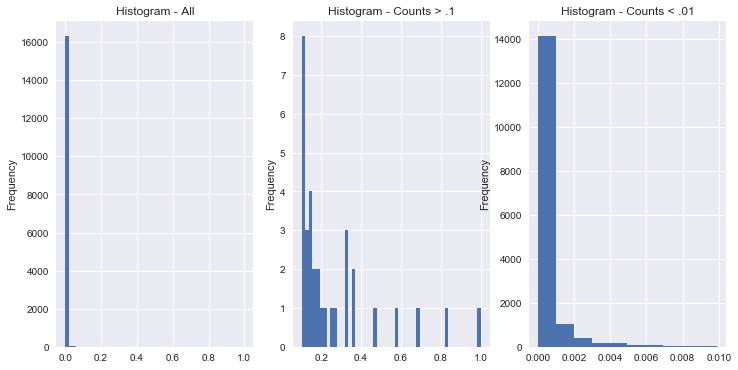

In [9]:
from sklearn.preprocessing import StandardScaler, minmax_scale

def hist_counts(word_counts):
    hist_counts = pd.Series(minmax_scale(word_counts), 
                            index=word_counts.index)
    
    # Overall graph is hard to understand, so let's break it into three graphs
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
    
    hist_counts.plot(kind="hist", bins=50, ax=axes[0], title="Histogram - All")
    
    # There are a lot of really common tokens within 10% -- filter them out
    hist_counts[hist_counts > .1].plot(kind="hist", bins=50, ax=axes[1], title="Histogram - Counts > .1")
    
    # look at the range of extreme commons that seem to exist below .01
    hist_counts[hist_counts < .01].plot(kind="hist", ax=axes[2], title="Histogram - Counts < .01")
    
hist_counts(freq_words)

#### 1.C. Try it again with stopword removal 

xa0       1223
like       718
xc2        615
just       557
don        436
people     419
know       328
think      302
fuck       242
x80        224
dtype: int64


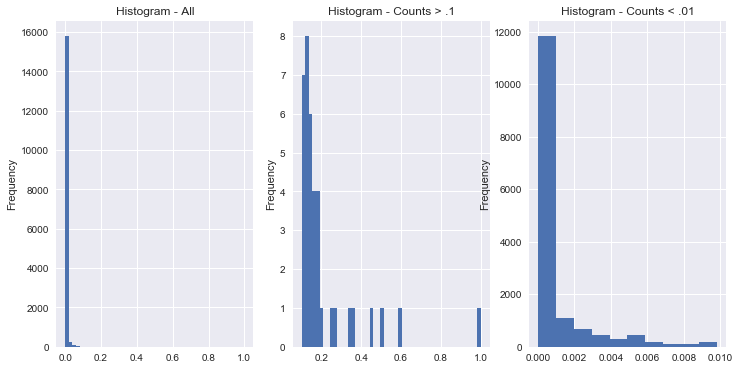

In [10]:
cvt      =  CountVectorizer(strip_accents='unicode', stop_words="english", ngram_range=(1,1))
X_all    =  cvt.fit_transform(insults_df['Comment'])
columns  =  np.array(cvt.get_feature_names())

freq_words = get_freq_words(X_all, columns)

print(freq_words[:10])
hist_counts(freq_words)

In [11]:
# Checking range between .99 - .99999 -- there seem to be lots of words there
freq_words.quantile(.99999)

1141.291000000072

In [12]:
# find the %1, and %10 threshold for masking
freq_words[(freq_words >= 10) & (freq_words <= 150)]

got           150
shit          148
idiot         144
better        137
life          133
look          129
gay           125
does          125
ll            124
years         118
said          118
money         115
come          108
bitch         108
white         106
day           104
big           100
year          100
lol           100
stop           98
let            95
post           94
ni             92
didn           92
love           90
doesn          90
thing          89
things         89
feel           89
dumb           88
             ... 
crime          10
events         10
hide           10
offensive      10
claiming       10
hi             10
enemies        10
hasn           10
te             10
core           10
episode        10
crack          10
sh             10
corporate      10
penalty        10
haters         10
interview      10
source         10
held           10
attempt        10
attacks        10
nasty          10
banned         10
politician     10
ideas     

#### 1.D. Explore ngrams between 2 and 4
Display the top 75 ngrams with frequencies.

In [13]:
cvt = CountVectorizer(stop_words="english", ngram_range=(2,4))
X_all = cvt.fit_transform(insults_df['Comment'])
columns  =  np.array(cvt.get_feature_names())

freq_words = get_freq_words(X_all, columns)
freq_words

xc2 xa0                             379
xe2 x80                             209
xa0 xa0                             144
http shar                            68
shar es                              68
http shar es                         68
trade trade                          63
trade trade trade                    62
trade trade trade trade              61
u2026 u2026                          59
xa0 xa0 xa0                          57
u2026 u2026 u2026                    52
xa0 xa0 xa0 xa0                      49
xa0 xc2                              46
xc2 xa0 xc2                          46
u2026 u2026 u2026 u2026              45
don know                             43
xe2 x80 x99s                         41
x80 x99s                             41
xc2 xa0 xc2 xa0                      35
xa0 xc2 xa0                          35
look like                            35
x80 x9d                              34
xe2 x80 x9d                          34
bit ly                               34


#### 1.E. (Optional) try expanding the list of stopwords
There are definitely some non-words such as xa0, x80, web urls, etc. If you could remove them, this could help us improve the score.  Identify word/tokens that don't add much value to either class.  **You should additionally look at ngrams per class (insults vs non-insults) to fine tune your preprocessing.  This has the greatest potential to improve your results without tuning any model parameters.**

Using `nltk.corpus`, we can get a baseline list of stop words.  Try to expand it and pass it to our vectorizer.

In [14]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop += ['xa0', 'x80', 'xc2', 'xe3']
stop.append("need")
stop.append("in")
stop.append("re")
stop.append("are")
stop.append("for")
stop.append("have")
stop.append("like")
stop.append("be")
stop.append("see")
stop.append("do")
stop.append("trade")
stop.append("u2026")
stop.append("http")
stop.append("mrzlgv")
stop.append("bit")
stop.append("ly")
stop.append("div")
stop.append("class")
stop.append("forum")
stop.append("item")
stop.append("shar")
stop.append("profile")
stop.append("es")

stop += ['people', 'go', 'know', 'think', 'get', 'us', 'really', 'way', 'xe2', 'got', 'want', 'well']

In [15]:
# These look pretty clean for a first step in anlaysis
cvt = CountVectorizer(stop_words=stop, lowercase=True, strip_accents="unicode", ngram_range=(1,2))
X_all = cvt.fit_transform(insults_df['Comment'])
columns  =  np.array(cvt.get_feature_names())

freq_words = get_freq_words(X_all, columns)
freq_words[:20]

would      371
one        360
fuck       242
right      223
time       219
make       211
good       207
back       189
even       185
say        183
little     174
ass        171
fucking    170
obama      159
never      154
going      154
stupid     154
man        153
shit       148
idiot      144
dtype: int64

### 2. Setup a test / train split of your data using any method you wish.
Try 70/30 to start.

In [16]:
# Find our training size
training_size = int(insults_df.shape[0] * .7)

# Randomly sample our training data
insults_train = insults_df.sample(n=training_size, replace=True)

# Capture the rest of the dataset that's not "training" using an inverse mask (rows NOT IN training dataframe)
mask = insults_df.index.isin(insults_train.index)
insults_test = insults_df[~mask]

# Should be (2762, 1963) = training / testing = 70/30
insults_train.shape[0], insults_test.shape[0]

(2762, 1953)

### 3. Setup a "Pipeline" to vectorize and use MultinomialNB classifier.
Use `lowercase`, `strip_accents`, `Pipeline`, and optionally your updated `stop_words`.  Fit your comment data using the "Insult" feature as your response.

Fit your training data to your pipeline, then score it.

In [17]:
# MultinomialNB
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=True, strip_accents='unicode', stop_words=stop)),
    ('tfidf', TfidfTransformer()),
    ('cls', MultinomialNB())
]) 
pipeline.fit(insults_train["Comment"], insults_train["Insult"])
predicted = pipeline.predict(insults_test["Comment"])
pipeline.score(insults_test["Comment"], insults_test["Insult"])

0.76190476190476186

In [18]:
# Alternative -- train on all data for later data mining of reddit comments
# MultinomialNB
pipeline = Pipeline([
    ('vect', cvt),
    # ('tfidf', TfidfTransformer()),
    ('cls', MultinomialNB())
]) 
pipeline.fit(insults_df["Comment"], insults_df["Insult"])
predicted = pipeline.predict(insults_df["Comment"])
pipeline.score(insults_df["Comment"], insults_df["Insult"])

0.98707879402077525

In [19]:
#  Add predicted probabilities back to original dataframe
insults_df['Predicted'] = predicted

#### 3.A. Swap out MultinomialNB with BernoulliNB in the pipeline
How do they compare?

In [20]:
# BernoulliNB
pipeline = Pipeline([
    ('vect', cvt),
    ('tfidf', TfidfTransformer()),
    ('cls', BernoulliNB())
]) 
pipeline.fit(insults_df["Comment"], insults_df["Insult"])
predicted = pipeline.predict(insults_df["Comment"])
pipeline.score(insults_df["Comment"], insults_df["Insult"])

0.79174056245249558

#### 3.B. Also try logistic regression and random forests in the pipeline
How do they compare? Recall that Logistic Regression is discriminative whereas Naive Bayes is generative. Logistic Regression uses optimization to fit a formula that discriminates between the classes, whereas Naive Bayes essentially just computes aggregate statistics. So, Logistic Regression should have a longer training time than Naive Bayes -- does it here? (see `%time`)

Note that Logistic Regression and Random Forests both allow you to see feature "importance"/coefficients. In this case, these coefficients will inform you how strong each word is an insult or not. Optionally, see if you can sort these coefficients by their values to get the strongest and weakest indicator words for insults.

In [21]:
# LogisticRegression
pipeline = Pipeline([
    ('vect', cvt),
    ('tfidf', TfidfTransformer()),
    ('cls', LogisticRegression())
]) 
pipeline.fit(insults_df["Comment"], insults_df["Insult"])
predicted = pipeline.predict(insults_df["Comment"])
pipeline.score(insults_df["Comment"], insults_df["Insult"])

0.82138332911071699

#### 3.C. Also try tweaking the paramters of CountVectorizer and TfidfTranformer

Remove Tfidf also. Good / bad?

In [22]:
# BernoulliNB
cvt2 = CountVectorizer(stop_words=stop, lowercase=True, strip_accents="unicode", ngram_range=(1,2))
pipeline = Pipeline([
    ('vect', cvt2),
    # ('tfidf', TfidfTransformer()),
    ('cls', LogisticRegression())
]) 
pipeline.fit(insults_df["Comment"], insults_df["Insult"])
predicted = pipeline.predict(insults_df["Comment"])
pipeline.score(insults_df["Comment"], insults_df["Insult"])

0.98707879402077525

### 4. Check your score.
Also, run a classification report and [plot AUC/ROC](../../week-04/2.3-evaluating_model_fit/code/AUC-ROC-codealong.ipynb).  Also, [review classfication reporting metrics](../../week-04/4.3-advanced-model_evaluation/code/starter-code/week4-4.1-classification-report.ipynb).

In [23]:
insults_test.shape, len(predicted)

((1953, 3), 3947)

In [24]:
predicted = pipeline.predict(insults_test["Comment"])
print classification_report(insults_test["Insult"], predicted, target_names=["Insult", "Neutral"])

             precision    recall  f1-score   support

     Insult       0.98      1.00      0.99      1433
    Neutral       1.00      0.95      0.97       520

avg / total       0.99      0.99      0.99      1953



### Revisiting:  Learning Curves

Let us reprise the idea of sample size effect on validation score.  How do we know the optimal sample size to train and test on?  We can examine the scores of training and cross validation given a number of samples.  Plotting the scores is a great way to understand:

- How to improve bias / generalization (out of sample prediction)
- Generally how many samples you might need
- The bounds of your models performance 

Generally, the learning curves represent the number of samples that have been used, the average scores on the training sets and the average scores on the validation sets.  

See also [validation curves](http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#example-model-selection-plot-validation-curve-py) for model parameter *(aka: hyper parameter)* tuning, also [calibration plots](http://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html).

In [25]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

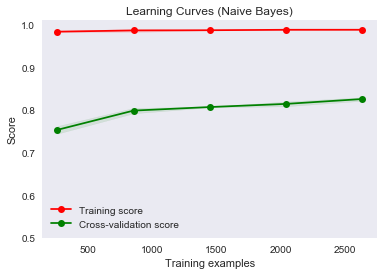

In [26]:
# Pipeline variable can be replaced by your already established estimator
learning_plt = plot_learning_curve(pipeline, "Learning Curves (Naive Bayes)", insults_df['Comment'], insults_df['Insult'], ylim=(0.5, 1.01), cv=3, n_jobs=4)

learning_plt.show()

In [27]:
def multi_roc(y, probs):
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(cv):
        # probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [28]:
from sklearn.metrics import roc_curve

def plot_roc(y, probs, threshmarkers=None):
    fpr, tpr, thresh = roc_curve(y, probs)

    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, lw=2)
   
    plt.xlabel("False Positive Rate\n(1 - Specificity)")
    plt.ylabel("True Positive Rate\n(Sensitivity)")
    plt.xlim([-0.025, 1.025])
    plt.ylim([-0.025, 1.025])
    plt.xticks(np.linspace(0, 1, 21), rotation=45)
    plt.yticks(np.linspace(0, 1, 21))
    plt.show()

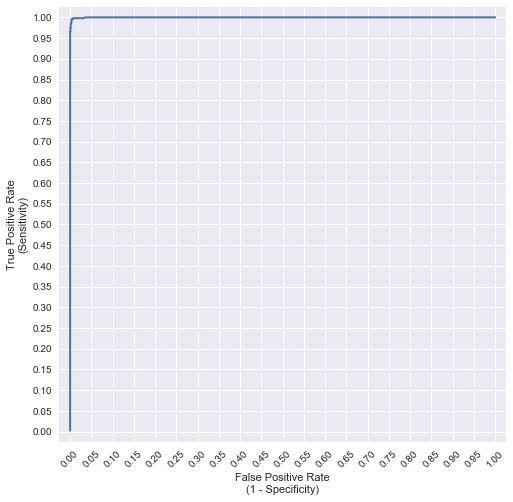

In [29]:
predicted_proba = pipeline.predict_proba(insults_test['Comment'])
plot_roc(insults_test['Insult'], predicted_proba[:, 1])

### 5 Check out your baseline.

What is the chance that you will randomly guess correctly without any modeling? Insult vs neutral.

In [30]:
insults_train.Insult.sum() * 1.0 / insults_train.Insult.count() * 1.0

0.2614047791455467

### 6. Check the accuracy of your model with the holdout dataset "test_with_solutions.csv"

Using the `test_with_solutions.csv`, we will test our model on another set of data it has never seen before.  Also plot the same eval metrics (classification report, AUC/ROC).

In [31]:
test_df = pd.read_csv("datasets/test_with_solutions.csv", encoding="utf-8")
test_df.head()

pipeline.score(test_df['Comment'], test_df['Insult'])

0.82281828485077446

### 7. What is your model not getting right?

Check out false positives and true negatives.  Any noticable patterns? Can you explain why many of these are incorrectly classified, given what you know about how Naive Bayes works?  Pay particular attention to the recall metric.  What might be done in preprocessing steps to improve accuracy?  

- Try to improve with your **preprocessing first**
- THEN try to tweak your **parameters to your model(s)**

In [32]:
predicted = pipeline.predict(insults_df["Comment"])

# Incorrectly classified
false_positives = insults_df[(predicted == 1) & (insults_df['Insult'] == 0)]
true_negatives = insults_df[(predicted == 0) & (insults_df['Insult'] == 1)]

# To view each comment in its entirety (Pandas has a set col width)
for comment in true_negatives['Comment']:
    print(comment)

"your such a dickhead..."
"fuck you both"
"That's because you're a nobody."
"More people on here than you, you cunt."
"You are a child."
"You're a bum"
"you're a tard"
"No people like you are the problem we are having in this world."
"You're a fucking joke."
"fuck your god."
"Like you Know Fck Face."
"fucking savages"
"You're a turd."
"You are a pig."
"We're not the losers but\xa0 you and this country are."
"fucking idiots"
"With a screen name like yours, you need to s..t..f..u.."
"F v < k you too."
"And you are a weak bully!"
"AND YOU POSTAL, WERE HATCHED"
"Yep, you're a darky."
"like your mom"
"W T F are you ranting about adolf?"
"have you been living under a rock kaden?"
"You are too_stupid to breathe! "
"Fuck you."
"What are you guys smoking?"
"_yeah_i_bet_you're_a_occupy_fucking_nigger!"
"you is shit"
"That guy is a real fuckstick."
"You are a born m o r o n."
"That's because you're all morons."
"Are you proud of your trolls?"
"You are the disgusting one."
"You are a traitor."
"go

## Lastly...

[this blog post](http://webmining.olariu.org/my-first-kaggle-competition-and-how-i-ranked/) by a guy who used SVM, a "neural network", a ton of cleaning, then placed 3rd in a Kaggle competition featuing this same dataset. Also [this blog post](http://peekaboo-vision.blogspot.de/2012/09/recap-of-my-first-kaggle-competition.html) -- he got 6th place and found the best model was a simple Logistic Regression! Given that you used a few basic techniques with preprocessing text and Naive Bayes, what do think about the tradeoffs of simplicity vs complexity of your model?